In [352]:
import pandas as pd 
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.impute import SimpleImputer

una tienda Superstore está buscando su conocimiento para entender lo que funciona mejor para ellos. Les gustaría entender qué productos, regiones, categorías y segmentos de clientes deben dirigirse o evitar

### LIMPIEZA DE DATOS

##### LECTURA DEL DF

In [353]:
path='C:/Users/andre/Downloads/data_market.csv'
df=pd.read_csv(path,encoding='ISO-8859-1',delimiter=';',index_col='Row ID')


##### TAMAÑO DEL DF

In [354]:
print(f'el tamaño del dataframe es de {df.shape[0]} filas y {df.shape[1]} columnas')

el tamaño del dataframe es de 9994 filas y 20 columnas


##### TIPO COLUMNAS

In [355]:
columnas_numericas=df.select_dtypes(include=['number']).columns
columnas_categoricas=df.select_dtypes(include=['object']).columns
print(f'la cantidad de columnas numericas es {len(columnas_numericas)} y la de categoricas es {len(columnas_categoricas)}')

la cantidad de columnas numericas es 3 y la de categoricas es 17


##### CAMBIAR TIPO STRING A FLOAT

In [356]:
def remplazos(df):
    df['Profit'] = df['Profit'].str.replace('.','')
    df['Profit'] = df['Profit'].astype('Float64')
    df['Sales'] = df['Sales'].str.replace('.','')
    df['Sales'] = df['Sales'].astype('Float64')
    
    return df
    

In [357]:
df=remplazos(df)

##### VALORES NULLOS 

In [358]:
nullos=df.isnull().sum().reset_index()
nullos=nullos.rename(columns={'index':'columnas',0:'nullos_c'})
nullos=nullos[nullos.nullos_c>0]
nullos=nullos.set_index('columnas')
print(f'el numero de columnas con datos nullos es de {nullos.shape[0]}\
 para un total de {np.array(nullos.nullos_c).sum()} datos nullos en todo el data set')
nullos


el numero de columnas con datos nullos es de 4 para un total de 24 datos nullos en todo el data set


,nullos_c
columnas,
Sales,6
Quantity,6
Discount,6
Profit,6


##### FILTRAR VALORES NULLOS EN DF 

In [359]:
filtered_df = df[df.isna().any(axis=1)]

##### % VALORES NULLOS 

In [360]:
nullos['%']=round((nullos['nullos_c']/df.shape[0])*100,3)
nullos.loc['total'] = ['=',np.array(nullos['%']).sum()]
nullos

,nullos_c,%
columnas,,
Sales,6,0.06
Quantity,6,0.06
Discount,6,0.06
Profit,6,0.06
total,=,0.24


##### REMPLAZAR NULLOS POR PROMEDIO

In [361]:
#df.replace(np.nan, 0,inplace=True)
# Reemplazar TSH por la media
mean_imputer = SimpleImputer(strategy='mean')
df.loc[:,['Sales','Quantity','Discount','Profit']] \
        = mean_imputer.fit_transform(df[['Sales','Quantity','Discount','Profit']])


In [362]:
# SE VERIFICA QUE NO HAY VALORES NULLOS
df.isnull().values.any()

False

##### VALORES DUPLICADOS

In [363]:
df.index.duplicated().sum()

0

##### SELECCION DE FEATURES Y AGREGAR FUNCIONES DE TIEMPO

In [364]:
def tiempo(df):
    df['Ship Date'] = pd.to_datetime(df['Ship Date'])
    df['año']=df['Ship Date'].dt.year
    df['mes']=df['Ship Date'].dt.month
    df['dia']=df['Ship Date'].dt.day
    return df

In [365]:
# se borra pais por que solo tiene un solo country 
df__=df.loc[:,['Ship Date','Ship Mode','Customer Name','Segment','City','State','Category','Sub-Category','Quantity','Profit']]
df__=tiempo(df__)


##### VALORES UNICOS 

In [366]:
def unicos(df):
    unicos={i:df[i].nunique()  for i in df.columns }
    return pd.DataFrame(unicos,index=['unicos'])\
            .T.sort_values(by='unicos',ascending=True)

In [367]:
unicos_=unicos(df__)
unicos_

,unicos
Segment,3
Category,3
Ship Mode,4
año,5
mes,12
Quantity,15
Sub-Category,17
dia,31
State,49
City,531


Al examinar los valores únicos, se puede detectar la diversidad y la distribución de los datos en cada variable, lo que ayuda a comprender mejor las relaciones y patrones presentes

##### MEDIDAS ESTADISTICAS  PROFIT

In [368]:
promedio_profit=round(np.array(df__['Profit']).mean(),0)
max_profit=round(np.array(df__['Profit']).max(),0)
min_profit=round(np.array(df__['Profit']).min(),0)
desv_=round(np.array(df__['Profit']).std(),0)
Q1=np.percentile(np.array(df__['Profit']),25)
Q3=np.percentile(np.array(df__['Profit']),75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

##### RESUMEN ESTADISTICO

In [369]:
resumen={
    'promedio_profit':promedio_profit,
    'max_profit':max_profit,
    'min_profit':min_profit,
    'desv_':desv_,
    'Q1':Q1,
    'Q3':Q3,
    'limite_inferior':limite_inferior,
    'limite_superior':limite_superior
}
resumen=pd.DataFrame(resumen,index=['resumen'])
resumen

,promedio_profit,max_profit,min_profit,desv_,Q1,Q3,limite_inferior,limite_superior
resumen,179906.0,67199808.0,-38399904.0,1722850.0,2245.0,151083.0,-221012.0,374340.0


##### AGRUPAR DATOS
#### segmento clientes

##### conteo por segmento

In [370]:
# segmento por cliente
segmento=df__.groupby(['Segment'])['Segment'].count()
segmento=segmento.reset_index(name='conteo')
segmento


,Segment,conteo
0,Consumer,5191
1,Corporate,3020
2,Home Office,1783


##### pivot por segmentos y año

In [371]:
tabla_pivote = pd.pivot_table(
    df__, 
    values='Profit',        
    index='año',            
    columns='Segment',      
    aggfunc='sum',          
    fill_value=0            
)
tabla_pivote

Segment,Consumer,Corporate,Home Office
año,,,
2014,193875516.0,95779457.472267,58063248.472267
2015,120809995.0,139586641.0,55521900.0
2016,243913148.0,129620601.0,118792889.944533
2017,347802436.472267,141522797.0,145368800.472267
2018,4757196.0,2630155.0,-59498.0


In [372]:
tabla_pivote_seg_mes

Segment,Consumer,Corporate,Home Office
mes,,,
1,32969337.0,22793843.0,20465773.0
2,23482494.0,19301310.0,12585949.0
3,137283478.0,64608756.0,13837251.0
4,9334217.0,60864346.0,8573363.4168
5,76730224.0,45545503.0,20154625.472267
6,71235490.0,22800172.0,22705883.0
7,27028385.0,26748256.0,7574048.0
8,67517062.0,51108003.0,9502544.0
9,153056185.472267,52563564.0,50627992.0


#### ciudad y region

##### conteo por ciudad y suma de profit

In [373]:
ciudad=df__.groupby(['City'])['Profit'].sum()
ciudad=ciudad.reset_index(name='sum').sort_values(by='sum',ascending=False).head(21)
ciudad['valores'] = ciudad['sum'].apply(lambda x: '{:,.0f}'.format(x))
conteo=df__.groupby(['City'])['City'].count()
conteo=conteo.reset_index(name='conteo')
df_result=pd.merge(ciudad,conteo,on='City').sort_values(by='conteo',ascending=False)
df_result=df_result.head(6)
df_result


,City,sum,valores,conteo
0,New York City,389435030.0,"389,435,030",915
2,Los Angeles,178925628.0,"178,925,628",747
3,San Francisco,114998620.0,"114,998,620",510
1,Seattle,219116376.0,"219,116,376",428
11,Columbus,36567232.0,"36,567,232",222
9,San Diego,41332287.0,"41,332,287",170


##### profit estado

In [374]:
estado=df__.groupby(['State'])['Profit'].sum()
estado=estado.reset_index(name='sum').sort_values(by='sum',ascending=False).head(21)
estado['valores'] = estado['sum'].apply(lambda x: '{:,.0f}'.format(x))
estado=estado.iloc[:,[0,2]]
estado


,State,valores
30,New York,"474,152,868"
3,California,"456,584,921"
45,Washington,"243,373,153"
20,Michigan,"116,291,759"
44,Virginia,"113,575,719"
9,Georgia,"87,997,758"
6,Delaware,"87,637,536"
21,Minnesota,"79,633,762"
28,New Jersey,"72,401,896"
15,Kentucky,"67,409,238"


#### categoricas

##### categorias mas frecuentes

In [375]:
categoria=df__.groupby('Category')['Category'].count()
categoria=categoria.reset_index(name='conteo')
categoria_s=df__.groupby('Category')['Profit'].sum()
categoria_s=categoria_s.reset_index(name='suma')
categoria_s['valores'] = categoria_s['suma'].apply(lambda x: '{:,.0f}'.format(x))
categoria_s=pd.merge(categoria,categoria_s,on='Category').sort_values(by='suma',ascending=False)


In [376]:
tabla_pivote_categoria = pd.pivot_table(
    df__, 
    values='Profit',        
    index='año',            
    columns='Category',      
    aggfunc='sum',          
    fill_value=0            
)

##### ventas a lo largo del tiempo

In [377]:
años_=df__.groupby('año')['año'].count()
años_=años_.reset_index(name='conteo')
años_profit=df__.groupby('año')['Profit'].sum()
años_profit=años_profit.reset_index(name='suma')
años_profit['valores'] = años_profit['suma'].apply(lambda x: '{:,.0f}'.format(x))
años_resumen=pd.merge(años_,años_profit,on='año').sort_values(by='año',ascending=False)
años_resumen=años_resumen


#####  Graficos

##### grafica  de tendencia de pedidos

¿ que tipo de tendencia tiene los pedidos en los ultimos años?

¿ Se experimentó una desaceleración en las ganancias?

In [378]:
plt.style.use('seaborn-v0_8')

In [379]:
años_=df__.groupby('año')['año'].count()
años_=años_.reset_index(name='conteo')
años_profit=df__.groupby('año')['Profit'].sum()
años_profit=años_profit.reset_index(name='suma')
años_profit['valores'] = años_profit['suma'].apply(lambda x: '{:,.0f}'.format(x))
años_resumen=pd.merge(años_,años_profit,on='año').sort_values(by='año',ascending=False)
años_resumen=años_resumen

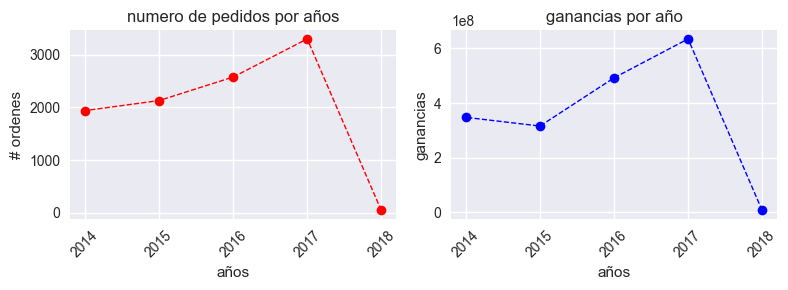

In [380]:
fig,ax = plt.subplots(1,2, figsize=(8, 3))

ax[0].plot(años_resumen['año'],años_resumen['conteo'],color='red',marker='o',linestyle='--',linewidth=1)
ax[1].plot(años_resumen['año'],años_resumen['suma'],color='b',marker='o',linestyle='--',linewidth=1)

ax[0].tick_params(axis='x', rotation=45)
ax[0].set_xlabel('años')
ax[0].set_ylabel('# ordenes')
ax[0].set_title('numero de pedidos por años')

ax[1].tick_params(axis='x', rotation=45)
ax[1].set_xlabel('años')
ax[1].set_ylabel('ganancias')
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_title('ganancias por año')

plt.tight_layout()
plt.show()



##### grafica  de ganancias por segmento 

¿Existen diferencias significativas en el comportamiento de las ganancias entre los tres segmentos?

¿Existe alguna tendencia general en las ganancias a lo largo del año?

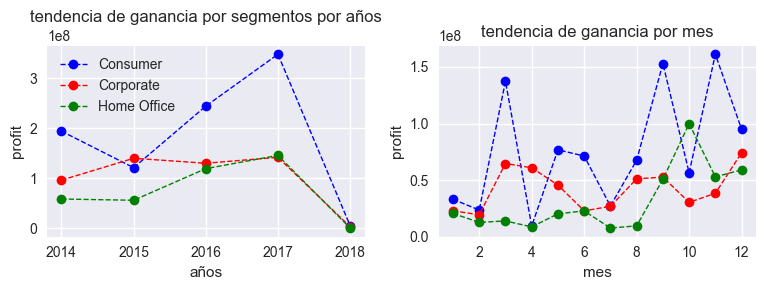

In [381]:
fig , ax =plt.subplots(1,2,figsize=(8, 3))

ax[0].plot(tabla_pivote.index,tabla_pivote['Consumer'],color='b',marker='o',linestyle='--',linewidth=1,label='Consumer')
ax[0].plot(tabla_pivote.index,tabla_pivote['Corporate'],color='r',marker='o',linestyle='--',linewidth=1,label='Corporate')
ax[0].plot(tabla_pivote.index,tabla_pivote['Home Office'],color='g',marker='o',linestyle='--',linewidth=1,label='Home Office')
ax[0].set_title('tendencia de ganancia por segmentos por años')
ax[0].set_ylabel('profit')
ax[0].set_xlabel('años')

ax[1].plot(tabla_pivote_seg_mes.index,tabla_pivote_seg_mes['Consumer'],color='b',marker='o',linestyle='--',linewidth=1,label='Consumer')
ax[1].plot(tabla_pivote_seg_mes.index,tabla_pivote_seg_mes['Corporate'],color='r',marker='o',linestyle='--',linewidth=1,label='Corporate')
ax[1].plot(tabla_pivote_seg_mes.index,tabla_pivote_seg_mes['Home Office'],color='g',marker='o',linestyle='--',linewidth=1,label='Home Office')
ax[1].set_title('tendencia de ganancia por mes')
ax[1].set_ylabel('profit')
ax[1].set_xlabel('mes')


ax[0].legend()

plt.tight_layout()
plt.show()

##### grafica  numero de ordenes y ganancia por categoria y años

¿ cual es la categoria mas rentable?

¿ cual de las categorias registra  los ingresos mas sostenidos?

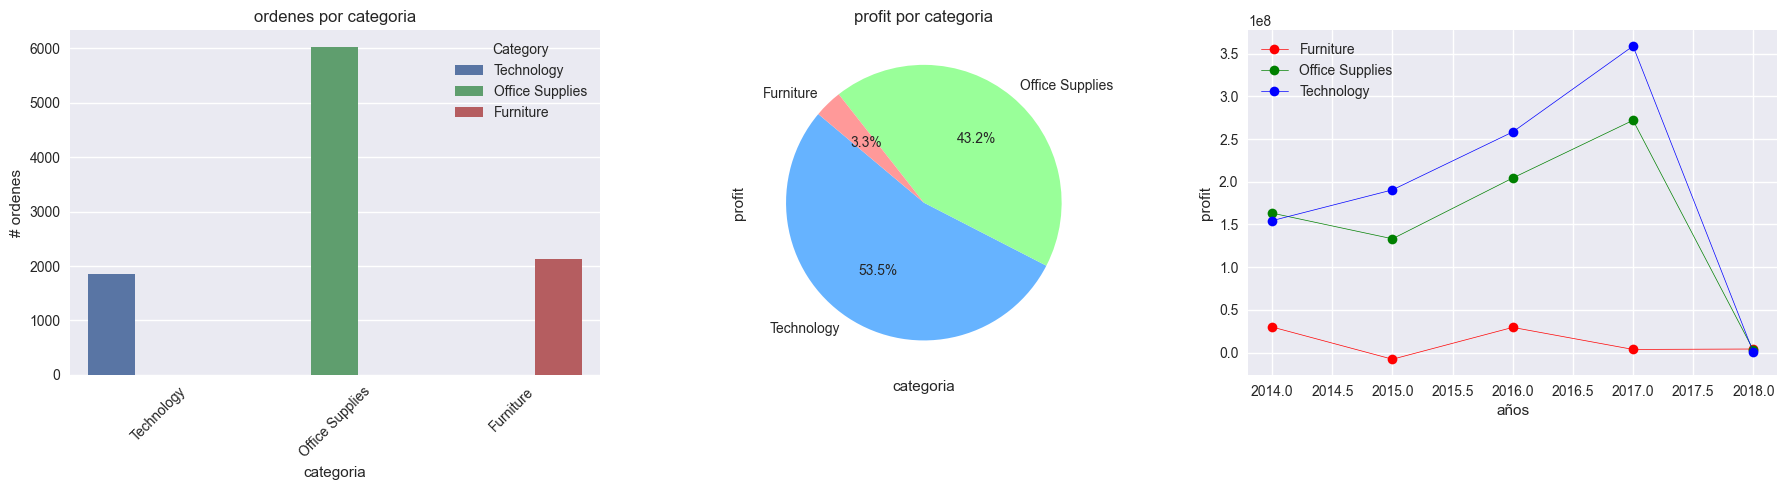

In [382]:
fig , ax =plt.subplots(1,3,figsize=(18, 5))

sns.barplot(x=categoria_s.Category,y=categoria_s.conteo,data=categoria_s,hue='Category',ax=ax[0])
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_title('ordenes por categoria')
ax[0].set_ylabel('# ordenes')
ax[0].set_xlabel('categoria')

ax[2].set_xlabel('años')
ax[2].set_ylabel('profit')

ax[2].plot(tabla_pivote_categoria.index,tabla_pivote_categoria['Furniture'],color='r',marker='o',linestyle='-',linewidth=0.5,label='Furniture')
ax[2].plot(tabla_pivote_categoria.index,tabla_pivote_categoria['Office Supplies'],color='g',marker='o',linestyle='-',linewidth=0.5,label='Office Supplies')
ax[2].plot(tabla_pivote_categoria.index,tabla_pivote_categoria['Technology'],color='b',marker='o',linestyle='-',linewidth=0.5,label='Technology')
ax[2].legend()

ax[1].pie(categoria_s['suma'], labels=categoria_s['Category'], autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#99ff99','#ff9999','#ffcc99'])
ax[1].set_title('profit por categoria')
ax[1].set_ylabel('profit')
ax[1].set_xlabel('categoria')

plt.tight_layout()

plt.show()

grafica de profit por ciudad

¿cual es el margen de beneficio para cada ciudad?

¿Existe alguna correlación entre el tamaño de la población de cada ciudad y los beneficios generados?

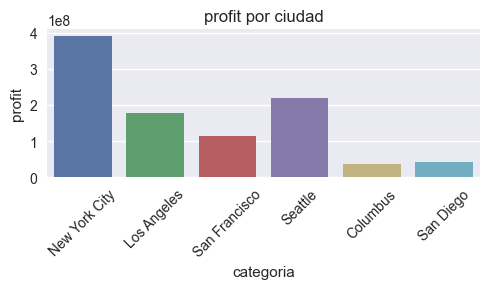

In [383]:
fig, ax = plt.subplots(figsize=(5, 3))

# Crear gráfico de barras verticales
sns.barplot(x='City', y='sum', data=df_result)

ax.set_title('profit por ciudad')
ax.set_ylabel('profit')
ax.set_xlabel('categoria')

# Ajustar las etiquetas del eje x
ax.tick_params(axis='x', rotation=45)
#plt.legend()
plt.tight_layout()

¿Cómo evolucionaron los beneficios de cada ciudad entre 2017 y 2018?

¿Cuál fue la ciudad más rentable en ambos años?

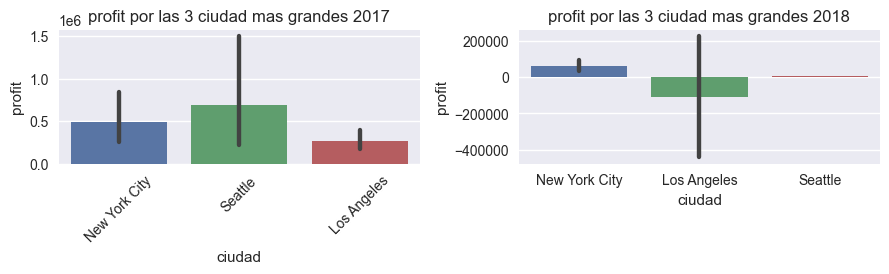

In [385]:
df__2=df__[ df__['City']\
    .isin(['New York City','Los Angeles','Seattle']) ]
df__2=df__2[df__2.año==2017]

df__3=df__[ df__['City']\
    .isin(['New York City','Los Angeles','Seattle']) ]
df__3=df__3[df__3.año==2018]


fig, ax = plt.subplots(1,2,figsize=(9, 3))

# Crear gráfico de barras verticales
sns.barplot(x='City', y='Profit', data=df__2,ax=ax[0],fill=True)
sns.barplot(x='City', y='Profit', data=df__3,ax=ax[1],fill=True)



ax[0].set_title('profit por las 3 ciudad mas grandes 2017')
ax[0].set_ylabel('profit')
ax[0].set_xlabel('ciudad')

ax[1].set_title('profit por las 3 ciudad mas grandes 2018')
ax[1].set_ylabel('profit')
ax[1].set_xlabel('ciudad')


#sns.scatterplot(data=df_result, x='conteo', y='sum',ax=ax[1])

# Ajustar las etiquetas del eje x
ax[0].tick_params(axis='x', rotation=45)
#plt.legend()
plt.tight_layout()